<a href="https://colab.research.google.com/github/fullstackDonya/exoplanet-classification/blob/main/Terre_Soleil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

        Date   Distance_km
0 2024-01-01 -2.941528e+06
1 2024-01-02 -1.466732e+06
2 2024-01-03 -4.516360e+04
3 2024-01-04  1.319079e+06
4 2024-01-05  2.622047e+06


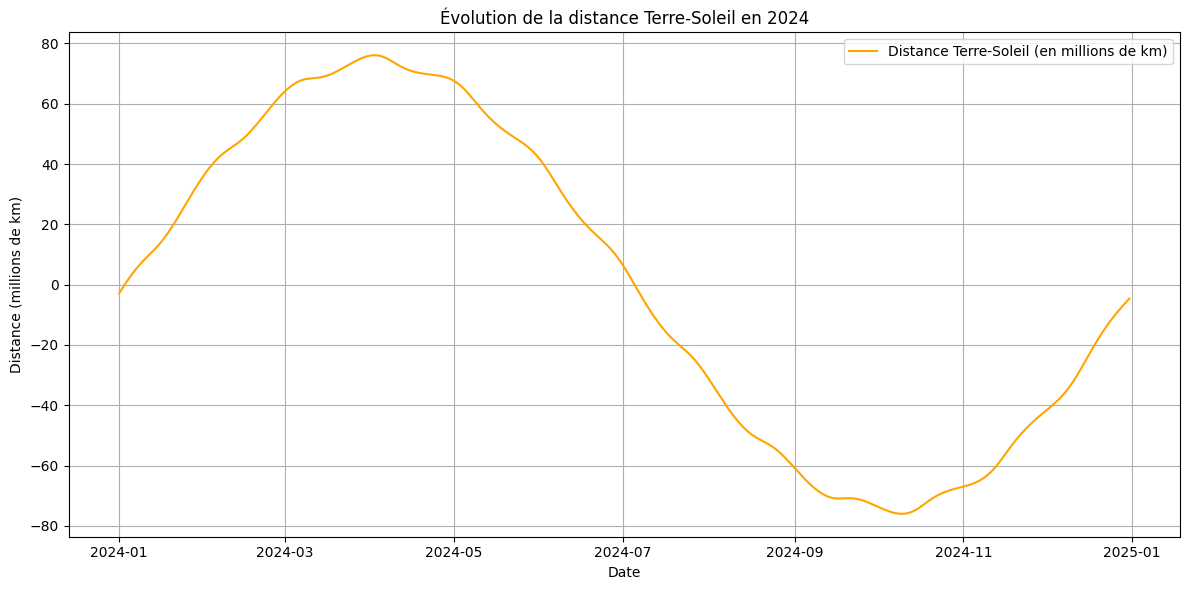

In [10]:
import requests
import pandas as pd
import io
import matplotlib.pyplot as plt

def get_distance_data(start_date, end_date):
    url = (
        "https://ssd.jpl.nasa.gov/api/horizons.api?"
        "format=text&COMMAND='399'&CENTER='@10'"
        f"&START_TIME='{start_date}'&STOP_TIME='{end_date}'&STEP_SIZE='1d'"
        "&QUANTITIES='20'"
    )

    response = requests.get(url)
    if response.status_code == 200:
        text = response.text
        # On extrait uniquement la partie des données entre les balises $$SOE et $$EOE
        data_start = text.find("$$SOE") + len("$$SOE\n")
        data_end = text.find("$$EOE")
        data_cleaned = text[data_start:data_end].strip()

        # Chaque ligne contient : date, distance (AU), etc. On garde la date et la distance
        # Exemple d'une ligne : "2020-Jan-01 00:00   0.983298665911"
        lines = data_cleaned.split("\n")
        rows = []
        for line in lines:
            parts = line.strip().split()
            date_str = f"{parts[0]} {parts[1]}"
            distance_au = float(parts[-1])  # En unité astronomique
            distance_km = distance_au * 149_597_870.7  # conversion AU -> km
            rows.append([date_str, distance_km])

        df = pd.DataFrame(rows, columns=["Date", "Distance_km"])
        df["Date"] = pd.to_datetime(df["Date"])
        return df
    else:
        print("Erreur dans la requête API")
        return None

# Obtenir les distances du 1er janvier 2024 au 31 décembre 2024
df_distance = get_distance_data("2024-01-01", "2024-12-31")

# Vérification
print(df_distance.head())

# Tracer la courbe
plt.figure(figsize=(12, 6))
plt.plot(df_distance["Date"], df_distance["Distance_km"] / 1e6, label="Distance Terre-Soleil (en millions de km)", color="orange")
plt.xlabel("Date")
plt.ylabel("Distance (millions de km)")
plt.title("Évolution de la distance Terre-Soleil en 2024")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


🌡️ Température moyenne estimée (modèle en équilibre radiatif)
La température moyenne de la Terre
𝑇
T (en Kelvin) peut être estimée par :

𝑇
=
(
(
1
−
𝐴
)
⋅
𝑆
4
⋅
𝜎
⋅
𝐷
2
)
1
/
4
T=(
4⋅σ⋅D
2

(1−A)⋅S
​
 )
1/4

Où :

𝐴
A = albédo terrestre moyen ≈ 0.3

𝑆
S = constante solaire ≈ 1361 W/m² (puissance reçue à 1 UA)

𝜎
σ = constante de Stefan-Boltzmann ≈ 5.67 × 10⁻⁸ W·m⁻²·K⁻⁴

𝐷
D = distance Terre-Soleil en UA

Cette formule suppose que la Terre est une sphère noire recevant le rayonnement solaire, sans atmosphère (≈ 255 K). Avec l’effet de serre, la température réelle moyenne est ≈ 288 K.

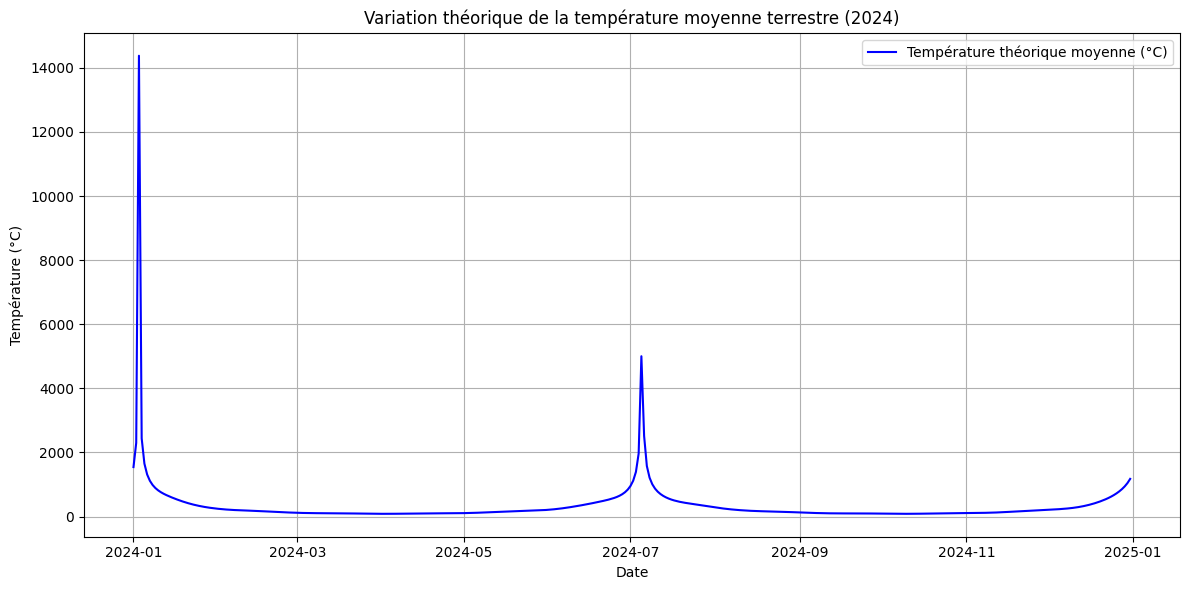

In [12]:
import numpy as np

def compute_temperature(distance_au, albedo=0.3, solar_constant=1361, sigma=5.67e-8):
    # D en unités astronomiques → on ramène à 1 UA
    return ((1 - albedo) * solar_constant / (4 * sigma * (distance_au ** 2))) ** 0.25

# Ajouter la distance en AU pour la formule
df_distance["Distance_AU"] = df_distance["Distance_km"] / 149_597_870.7
df_distance["Temp_K"] = df_distance["Distance_AU"].apply(compute_temperature)
df_distance["Temp_C"] = df_distance["Temp_K"] - 273.15  # conversion en °C

# Tracer la température
plt.figure(figsize=(12, 6))
plt.plot(df_distance["Date"], df_distance["Temp_C"], color="blue", label="Température théorique moyenne (°C)")
plt.xlabel("Date")
plt.ylabel("Température (°C)")
plt.title("Variation théorique de la température moyenne terrestre (2024)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


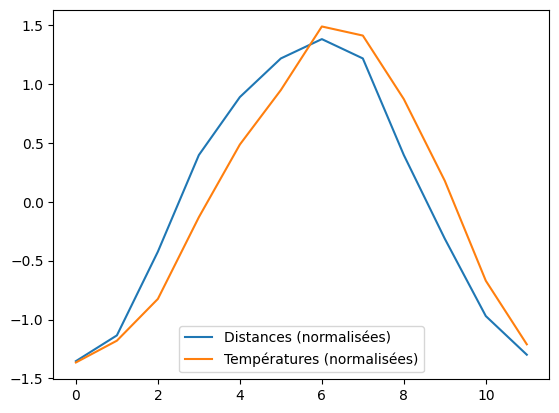

In [13]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Exemple de normalisation
scaler = StandardScaler()
# Distances et températures simulées
distances = [147.1, 147.5, 148.8, 150.3, 151.2, 151.8, 152.1, 151.8, 150.3, 149.0, 147.8, 147.2]
temperatures = [0.0, 1.2, 3.5, 8.0, 12.0, 15.0, 18.5, 18.0, 14.5, 10.0, 4.5, 1.0]

# Transformation des données
distances_scaled = scaler.fit_transform(pd.DataFrame(distances))
temperatures_scaled = scaler.fit_transform(pd.DataFrame(temperatures))

plt.plot(distances_scaled, label="Distances (normalisées)")
plt.plot(temperatures_scaled, label="Températures (normalisées)")
plt.legend()
plt.show()


In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Exemple de données
features = pd.DataFrame({'distance': distances_scaled.flatten(), 'temperature': temperatures_scaled.flatten()})
X = features[['distance']]
y = features['temperature']

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle
tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X_train, y_train)

# Prédiction et évaluation
predictions = tree_model.predict(X_test)
print("Prédictions des températures:", predictions)


Prédictions des températures: [-1.17975369 -0.8250565  -1.21059693]


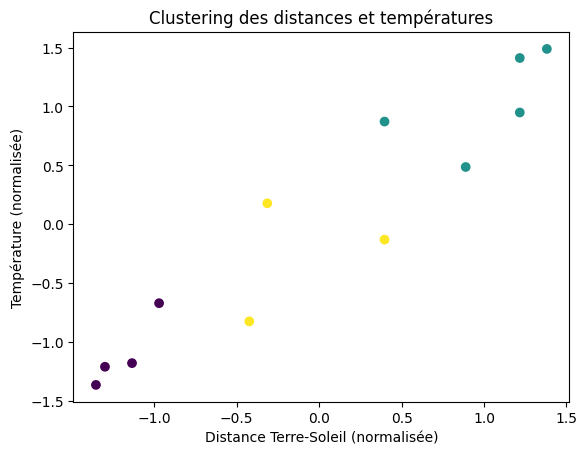

In [15]:
from sklearn.cluster import KMeans

# Créer et entraîner le modèle K-Means
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(features)

# Ajoutez les clusters pour visualisation
features['cluster'] = clusters

plt.scatter(features['distance'], features['temperature'], c=features['cluster'], cmap='viridis')
plt.xlabel('Distance Terre-Soleil (normalisée)')
plt.ylabel('Température (normalisée)')
plt.title("Clustering des distances et températures")
plt.show()


In [16]:
from sklearn.linear_model import Perceptron

# Création de données binaires pour la classification (exemple)
temperature_change = [1 if temp > 0 else 0 for temp in temperatures]  # 1 si temp > moyenne, 0 sinon

# Modèle Perceptron
perceptron = Perceptron()
X = pd.DataFrame({'distance': distances})
y = temperature_change
perceptron.fit(X, y)

# Prédictions
predictions = perceptron.predict(X)
print("Prédictions de la classification:", predictions)


Prédictions de la classification: [1 1 1 1 1 1 1 1 1 1 1 1]


In [17]:
from sklearn.neural_network import MLPRegressor

# Création d'un modèle de réseau de neurones
mlp = MLPRegressor(hidden_layer_sizes=(10, 5), activation='relu', max_iter=500)
mlp.fit(X_train, y_train)

# Prédictions et évaluation
predictions = mlp.predict(X_test)
print("Prédictions avec le réseau de neurones:", predictions)


Prédictions avec le réseau de neurones: [-1.03606492 -0.55559406 -1.28373733]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


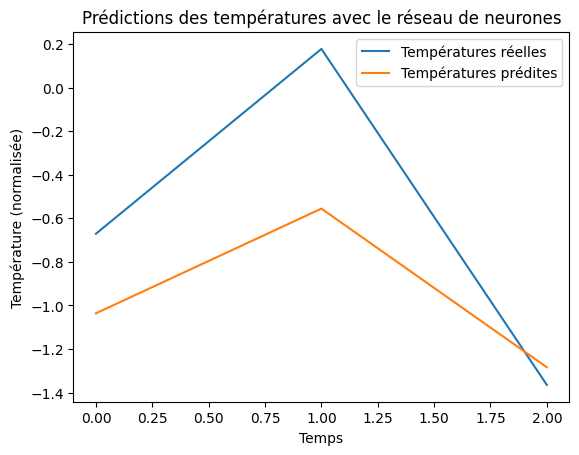

In [18]:
import matplotlib.pyplot as plt

# Visualisation des prédictions avec le réseau de neurones
plt.plot(y_test.reset_index(drop=True), label='Températures réelles')
plt.plot(predictions, label='Températures prédites')
plt.legend()
plt.title("Prédictions des températures avec le réseau de neurones")
plt.xlabel("Temps")
plt.ylabel("Température (normalisée)")
plt.show()


In [19]:
import pandas as pd

# Exemple de données simulées
data = {
    'date': pd.date_range(start='2000-01-01', periods=240, freq='M'),  # 20 ans de données mensuelles
    'temperature': [15 + i % 12 * 0.5 for i in range(240)]  # Exemple de variation cyclique
}
df = pd.DataFrame(data)

# Extraire les informations temporelles
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Calculer les moyennes mensuelles et annuelles
monthly_avg = df.groupby('month')['temperature'].mean()
annual_avg = df.groupby('year')['temperature'].mean()

print("Moyennes mensuelles :\n", monthly_avg)
print("Moyennes annuelles :\n", annual_avg)


Moyennes mensuelles :
 month
1     15.0
2     15.5
3     16.0
4     16.5
5     17.0
6     17.5
7     18.0
8     18.5
9     19.0
10    19.5
11    20.0
12    20.5
Name: temperature, dtype: float64
Moyennes annuelles :
 year
2000    17.75
2001    17.75
2002    17.75
2003    17.75
2004    17.75
2005    17.75
2006    17.75
2007    17.75
2008    17.75
2009    17.75
2010    17.75
2011    17.75
2012    17.75
2013    17.75
2014    17.75
2015    17.75
2016    17.75
2017    17.75
2018    17.75
2019    17.75
Name: temperature, dtype: float64


<ipython-input-19-dceb409084f3>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'date': pd.date_range(start='2000-01-01', periods=240, freq='M'),  # 20 ans de données mensuelles


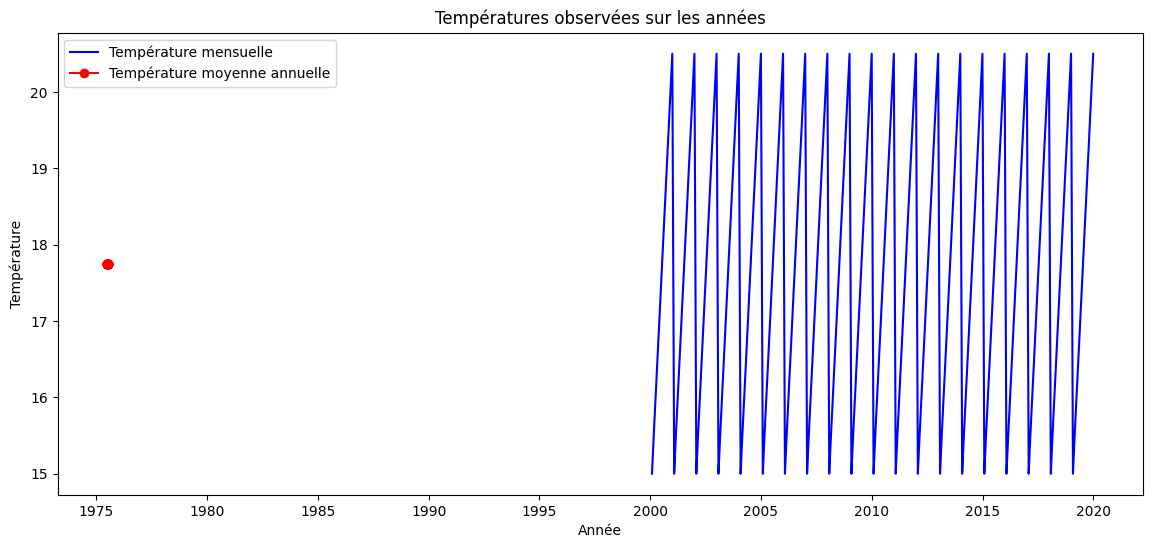

In [20]:
import matplotlib.pyplot as plt

# Tracer les températures mensuelles et annuelles
plt.figure(figsize=(14, 6))

# Données mensuelles
plt.plot(df['date'], df['temperature'], label='Température mensuelle', color='blue')

# Moyenne annuelle
plt.plot(df['date'].dt.year.unique(), annual_avg, label='Température moyenne annuelle', color='red', marker='o')

plt.xlabel("Année")
plt.ylabel("Température")
plt.title("Températures observées sur les années")
plt.legend()
plt.show()


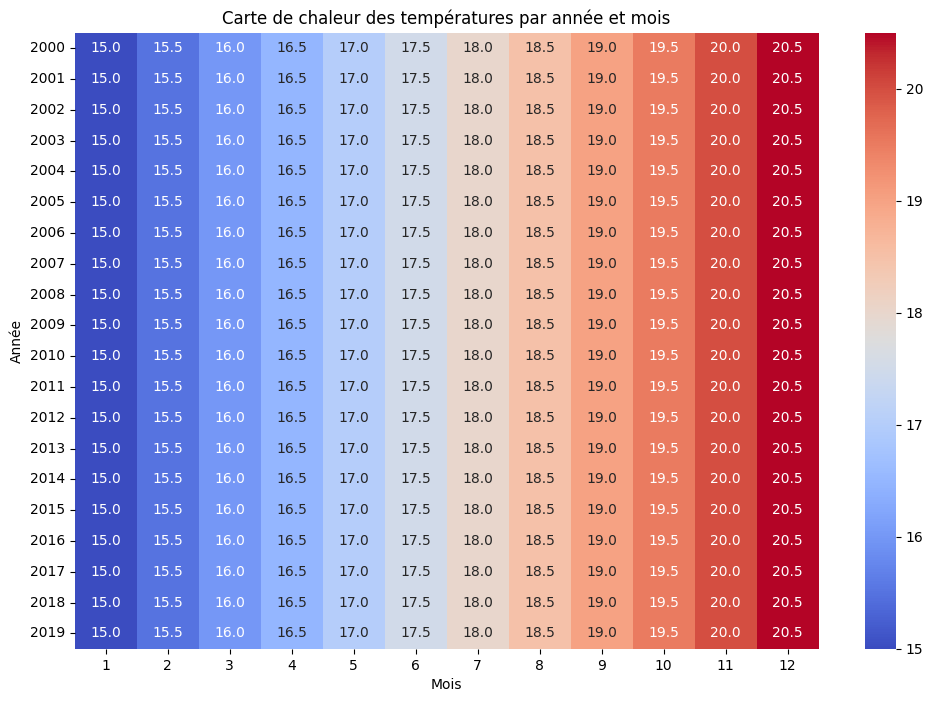

In [21]:
import seaborn as sns

# Restructurez les données pour la carte de chaleur
heatmap_data = df.pivot(index="year", columns="month", values="temperature")


# Création de la carte de chaleur
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Carte de chaleur des températures par année et mois")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.show()


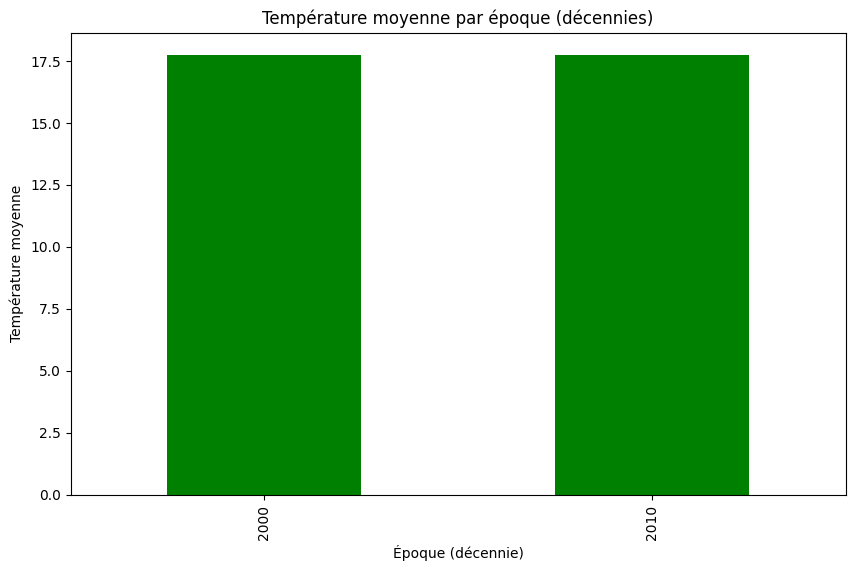

In [22]:
# Ajouter une colonne pour les époques (ex: chaque 10 ans)
df['epoch'] = (df['year'] // 10) * 10

# Calculer la température moyenne par époque
epoch_avg = df.groupby('epoch')['temperature'].mean()

# Visualisation par époque
plt.figure(figsize=(10, 6))
epoch_avg.plot(kind='bar', color='green')
plt.title("Température moyenne par époque (décennies)")
plt.xlabel("Époque (décennie)")
plt.ylabel("Température moyenne")
plt.show()


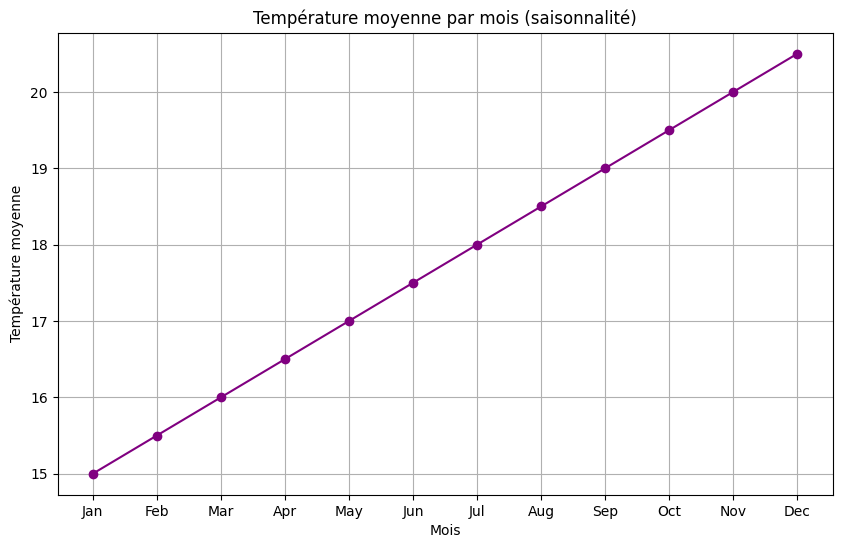

In [23]:
# Moyennes mensuelles sur toutes les années
monthly_avg_overall = df.groupby('month')['temperature'].mean()

# Visualisation des moyennes mensuelles
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_overall, marker='o', linestyle='-', color='purple')
plt.title("Température moyenne par mois (saisonnalité)")
plt.xlabel("Mois")
plt.ylabel("Température moyenne")
plt.xticks(range(1, 13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid()
plt.show()


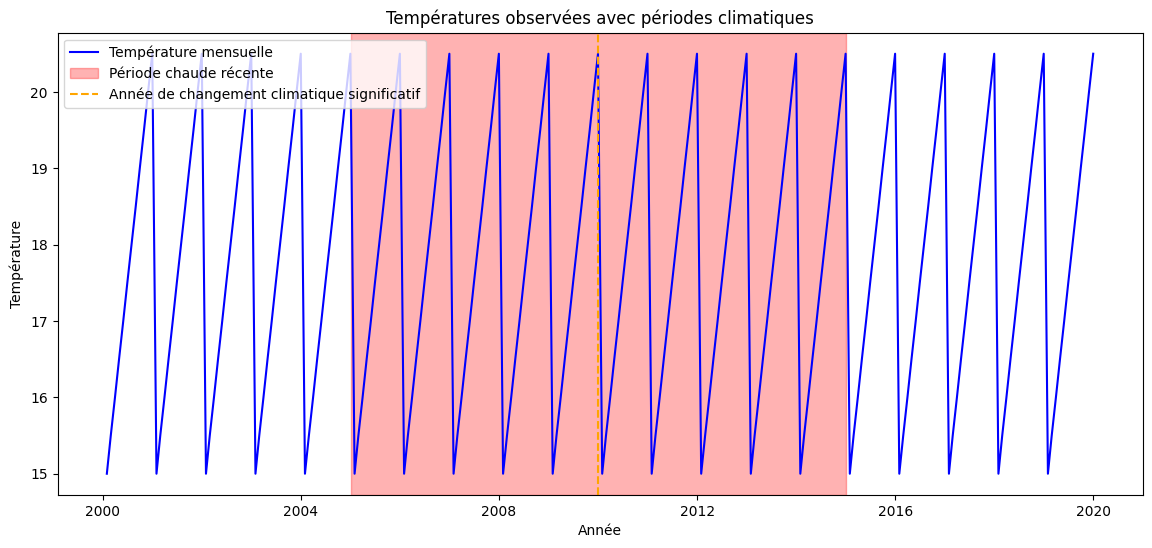

In [24]:
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['temperature'], color='blue', label="Température mensuelle")
plt.xlabel("Année")
plt.ylabel("Température")
plt.title("Températures observées avec périodes climatiques")

# Ajouter des annotations pour des périodes significatives
plt.axvspan(pd.Timestamp('2005-01-01'), pd.Timestamp('2015-01-01'), color="red", alpha=0.3, label="Période chaude récente")
plt.axvline(pd.Timestamp('2010-01-01'), color='orange', linestyle='--', label='Année de changement climatique significatif')

plt.legend()
plt.show()


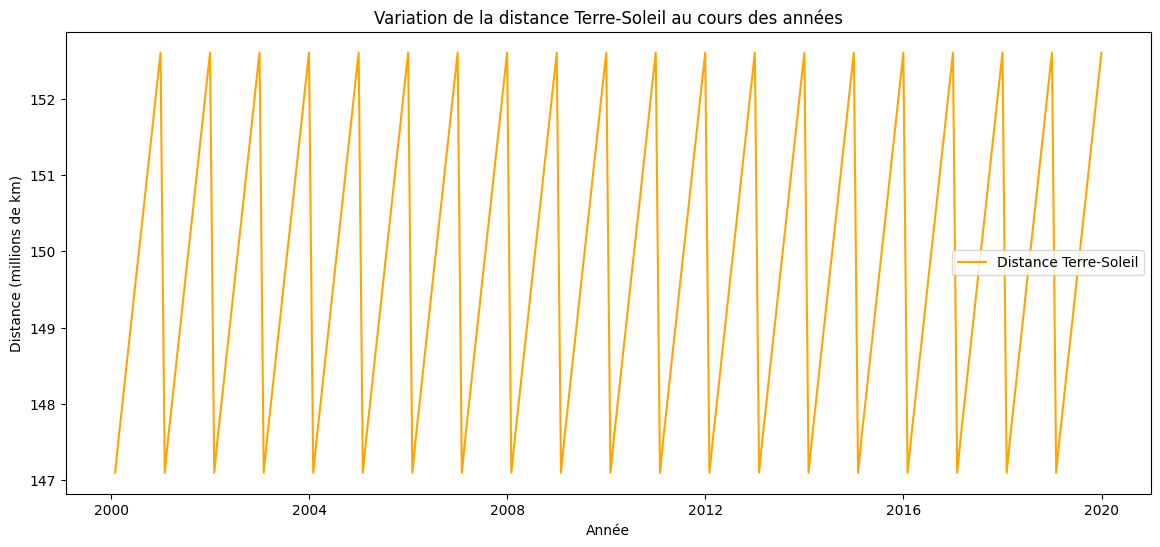

In [25]:
# Exemple de données pour distance Terre-Soleil (en millions de km)
df['distance_terre_soleil'] = [147.1 + (i % 12) * 0.5 for i in range(240)]  # données simulées

plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['distance_terre_soleil'], color='orange', label="Distance Terre-Soleil")
plt.xlabel("Année")
plt.ylabel("Distance (millions de km)")
plt.title("Variation de la distance Terre-Soleil au cours des années")
plt.legend()
plt.show()
